# Recommendation Systems

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract the file

In [1]:
#!unzip ml-100k.zip -d .

### Imports

In [2]:
# import required libraries
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from collections import Counter
import matplotlib.pyplot as plt


## Support functions and variables

In [3]:
MOVIELENS_DIR = "ml-100k"

In [4]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [5]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
rating_df.shape

(100000, 4)

In [8]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## I. Data Preprocessing and Baseline algorithms

### data processing

In [9]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    
    return matrix

In [10]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### baseline recommendation system
### popularity and user average rating

In [11]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ######################
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
            #if rating == 0:
                # Extract the items the user already rated
            userVector = train_matrix[user, :]
            ratedItems = userVector[userVector.nonzero()]

            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ######################
        # Initialize the predicted rating matrix with zeros
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            #if rating == 0:
            predictionMatrix[user, item] = itemPopularity[item]

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

        ######################
        return predictionMatrix 
        
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [12]:
popularity_recsys = BaseLineRecSys('popularity')

In [13]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [14]:
x = popularity_recsys.getModel()

In [15]:
x

array([[0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ]])

In [16]:
np.all(x<=1)

True

In [17]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:40, 2486.78it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [18]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [19]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [20]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [21]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:37, 2670.48it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## II. Collaborative Filtering

In [22]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ######################
        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='euclidean'))
        
        ######################    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ######################
        #similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='jaccard'))
        #similarity_matrix = (1 - pairwise_distances(matrix, metric='jaccard'))
        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='manhattan'))

        ######################     
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ###################### user-user similarity
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            
            if self.method_name == "cosine":
                similarity = self.cosine(train_matrix)
            elif self.method_name == "euclidean":
                similarity =  self.euclidean(train_matrix)
            else:
                similarity =  self.somethingelse(train_matrix)

            normalizer = np.matmul(similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start

            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            
            self.__model = predictionMatrix

            ######################
            
        elif self.base == 'item':
            ###################### item-item similarity
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            
            #transpose train_matrix into a item-user matrix
            train_matrix_transpose= np.transpose(train_matrix)
            
            if self.method_name == "cosine":
                similarity = self.cosine(train_matrix_transpose)
            elif self.method_name == "euclidean":
                similarity =  self.euclidean(train_matrix_transpose)
            else:
                similarity =  self.somethingelse(train_matrix_transpose)
            
            normalizer = np.matmul(temp_matrix,similarity)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(train_matrix, similarity)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start

            itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
            rows = np.sum(predictionMatrix, axis=1)
            predictionMatrix[rows == 0,:] = predictionMatrix[rows == 0,:] + np.expand_dims(itemaverage, axis=0)
            self.__model = predictionMatrix
            

            ######################
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [23]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [24]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [25]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

In [26]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [27]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [28]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [29]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [30]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:38, 2569.81it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


### cross validation

In [31]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [32]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

In [33]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:38, 2625.51it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


In [34]:
# How to use CrossValidation Class?

In [35]:
# 1. gather your algorithms in previous steps.
#algorithm_instances = [user_cosine_recsys,
#                      item_cosine_recsys]

In [36]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
#cv_patk = CrossValidation('RMSE')

In [37]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
#rmse_result = cv_patk.run(algorithm_instances, num_users, num_items,k=5)

In [38]:
# item_cosine_rmse_df = pd.DataFrame(columns = list(item_cosine_rmse_result.keys()),index=range(4))
# for elem in list(item_cosine_rmse_result.keys()):
#     item_cosine_rmse_df[elem].iloc[0] = item_cosine_rmse_result[elem][0]
#     item_cosine_rmse_df[elem].iloc[1] = item_cosine_rmse_result[elem][1]
#     item_cosine_rmse_df[elem].iloc[2] = item_cosine_rmse_result[elem][2]
#     item_cosine_rmse_df[elem].iloc[3] = item_cosine_rmse_result[elem][3]
# pd.set_option('display.max_colwidth', -1)
# item_cosine_rmse_df = item_cosine_rmse_df.rename(index={0: '5-fold score', 1: 'mean', 2: 'ci low',3:'ci high'})
# item_cosine_rmse_df

## III. Performance Comparison

## RMSE

In [39]:
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                      item_cosine_recsys]

In [40]:
cv_rmse = CrossValidation('RMSE')
rmse_result = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


337it [00:00, 3360.79it/s]

calculated 900 users


20000it [00:05, 3446.91it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


322it [00:00, 3219.86it/s]

calculated 900 users


20000it [00:05, 3420.46it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


350it [00:00, 3497.27it/s]

calculated 900 users


20000it [00:05, 3510.86it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


343it [00:00, 3425.51it/s]

calculated 900 users


20000it [00:05, 3467.64it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


352it [00:00, 3518.98it/s]

calculated 900 users


20000it [00:05, 3447.95it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3423.70it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3337.59it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:07, 2701.08it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2922.56it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3181.98it/s]
0it [00:00, ?it/s]

Processing algorithm user-cosine


20000it [00:06, 2971.49it/s]
20000it [00:06, 3023.46it/s]
20000it [00:06, 3202.52it/s]
20000it [00:06, 3204.73it/s]
20000it [00:06, 3205.72it/s]


Processing algorithm item-cosine


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3207.81it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3221.16it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3200.79it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3170.24it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3216.93it/s]


In [41]:
rmse_result

{'popularity': [[3.177941281084362,
   3.1750480150769977,
   3.147474655005899,
   3.146164503024159,
   3.1488360007536382],
  3.1590928909890112,
  3.139292746995387,
  3.1788930349826354],
 'useraverage': [[1.0629951276561334,
   1.0467467492319966,
   1.0328964562995389,
   1.0366575971298078,
   1.0392923504800367],
  1.0437176561595025,
  1.0289303496379316,
  1.0585049626810734],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135],
 'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226]}

In [42]:
rmse_df = pd.DataFrame(columns = list(rmse_result.keys()),index=range(4))

In [43]:
for elem in list(rmse_result.keys()):
    rmse_df[elem].iloc[0] = rmse_result[elem][0]
    rmse_df[elem].iloc[1] = rmse_result[elem][1]
    rmse_df[elem].iloc[2] = rmse_result[elem][2]
    rmse_df[elem].iloc[3] = rmse_result[elem][3]

In [44]:
rmse_df = rmse_df.rename(index={0: '5-fold score', 1: 'mean', 2: 'ci low',3:'ci high'})

In [45]:
rmse_df

,popularity,useraverage,user-cosine,item-cosine
5-fold score,"[3.177941281084362, 3.1750480150769977, 3.1474...","[1.0629951276561334, 1.0467467492319966, 1.032...","[1.026449013124381, 1.0214387664779507, 1.0132...","[1.0377631264364244, 1.0207280585350078, 1.010..."
mean,3.15909,1.04372,1.01735,1.02008
ci low,3.13929,1.02893,1.00901,1.00682
ci high,3.17889,1.0585,1.0257,1.03334


## P@K

In [46]:
cv_patk = CrossValidation('P@K')
patk_result = cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


311it [00:00, 3104.60it/s]

calculated 900 users


20000it [00:06, 3014.91it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3071.44it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3039.25it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3028.61it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


318it [00:00, 3178.06it/s]

calculated 800 users
calculated 900 users


20000it [00:06, 3177.74it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3325.46it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3315.36it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3353.08it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3330.61it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3272.61it/s]
0it [00:00, ?it/s]

Processing algorithm user-cosine


20000it [00:05, 3362.72it/s]
20000it [00:05, 3473.44it/s]
20000it [00:05, 3365.00it/s]
20000it [00:06, 3049.22it/s]
20000it [00:06, 3306.43it/s]


Processing algorithm item-cosine


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:05, 3337.47it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:05, 3496.72it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:05, 3475.42it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:05, 3494.47it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:05, 3492.91it/s]


In [47]:
patk_result

{'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943],
 'item-cosine': [[0.34316012725344736,
   0.483563096500532,
   0.6021208907741271,
   0.6248144220572649,
   0.6074231177094392],
  0.5322163308589621,
  0.3837005215009889,
  0.6807321402169354]}

In [48]:
patk_df = pd.DataFrame(columns = list(patk_result.keys()),index=range(4))
for elem in list(patk_df.keys()):
    patk_df[elem].iloc[0] = patk_result[elem][0]
    patk_df[elem].iloc[1] = patk_result[elem][1]
    patk_df[elem].iloc[2] = patk_result[elem][2]
    patk_df[elem].iloc[3] = patk_result[elem][3]
patk_df = patk_df.rename(index={0: '5-fold score', 1: 'mean', 2: 'ci low',3:'ci high'})
patk_df

,popularity,useraverage,user-cosine,item-cosine
5-fold score,"[0.36924708377518656, 0.4965005302226948, 0.61...","[0.30604453870625714, 0.4305408271474029, 0.53...","[0.37179215270413657, 0.503923647932133, 0.621...","[0.34316012725344736, 0.483563096500532, 0.602..."
mean,0.550583,0.473637,0.555843,0.532216
ci low,0.405441,0.341999,0.409598,0.383701
ci high,0.695725,0.605275,0.702088,0.680732


## R@K

In [49]:
cv_ratk = CrossValidation('R@K')
ratk_result = cv_ratk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


340it [00:00, 3392.43it/s]

calculated 900 users


20000it [00:05, 3478.35it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


343it [00:00, 3425.21it/s]

calculated 900 users


20000it [00:05, 3474.48it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


351it [00:00, 3502.89it/s]

calculated 900 users


20000it [00:05, 3478.90it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


346it [00:00, 3457.72it/s]

calculated 900 users


20000it [00:05, 3512.77it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


349it [00:00, 3489.06it/s]

calculated 900 users


20000it [00:05, 3510.27it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3484.54it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3453.88it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3463.96it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3465.39it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3496.25it/s]
0it [00:00, ?it/s]

Processing algorithm user-cosine


20000it [00:05, 3475.58it/s]
20000it [00:05, 3461.64it/s]
20000it [00:05, 3472.66it/s]
20000it [00:05, 3464.60it/s]
20000it [00:06, 3228.08it/s]


Processing algorithm item-cosine


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:05, 3457.74it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:05, 3481.39it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3189.33it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3235.12it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
20000it [00:05, 3420.94it/s]


In [50]:
ratk_result

{'popularity': [[0.3466588624187514,
   0.4274468698270901,
   0.5269205125667804,
   0.5518738761026849,
   0.5674793185065369],
  0.4840758878843688,
  0.3671373629798323,
  0.6010144127889052],
 'useraverage': [[0.30505841002027845,
   0.39554692074366876,
   0.48030412192442223,
   0.5045885853815734,
   0.5211179870422066],
  0.44132320502242983,
  0.32931026359142457,
  0.5533361464534351],
 'user-cosine': [[0.34778041993806913,
   0.4314035774468209,
   0.5293633772333985,
   0.5553818201403046,
   0.5674144230096255],
  0.4862687235536437,
  0.3694473610987218,
  0.6030900860085656],
 'item-cosine': [[0.3277711938444533,
   0.4237782250680911,
   0.5191391022223312,
   0.5448659224612776,
   0.5593011306991799],
  0.4749711148590666,
  0.35357317503649865,
  0.5963690546816346]}

In [51]:
ratk_df = pd.DataFrame(columns = list(ratk_result.keys()),index=range(4))
for elem in list(ratk_result.keys()):
    ratk_df[elem].iloc[0] = ratk_result[elem][0]
    ratk_df[elem].iloc[1] = ratk_result[elem][1]
    ratk_df[elem].iloc[2] = ratk_result[elem][2]
    ratk_df[elem].iloc[3] = ratk_result[elem][3]
ratk_df = ratk_df.rename(index={0: '5-fold score', 1: 'mean', 2: 'ci low',3:'ci high'})
ratk_df

,popularity,useraverage,user-cosine,item-cosine
5-fold score,"[0.3466588624187514, 0.4274468698270901, 0.526...","[0.30505841002027845, 0.39554692074366876, 0.4...","[0.34778041993806913, 0.4314035774468209, 0.52...","[0.3277711938444533, 0.4237782250680911, 0.519..."
mean,0.484076,0.441323,0.486269,0.474971
ci low,0.367137,0.32931,0.369447,0.353573
ci high,0.601014,0.553336,0.60309,0.596369


Popularity-based recommendation can not be evaluated by RMSE because popularity is calculated as (number of users liked/number of users rate), where the actual ratings are from 1-5.

user-cosine outperfroms all other three recommendation baselines in all three measurements. user-cosine has way more entries than other three recommendations so it helps reducing bias and improve performance.

Good performance on RMSE does not imply good performance in ranking matrix becuase RMSE is only indicates Euclidean distance between predictions but in ranking the focus is on the ratio of accurate predictions in the first several predictions.<br>
Good performance on ranking matrics does not imply good performance in RMSE as well. It only guarantees the first several predictions we care about is accurate and has low RMSE value but it does not hold for overall RMSE.

## IV. Similarity Evaluation

### (a)

In [52]:
np.seterr(divide='ignore', invalid='ignore')
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [53]:
movies_matrix = moviesDF.as_matrix()[:, 5:]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [54]:
movies_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

In [55]:
movies_matrix.shape

(1682, 19)

In [56]:
movis_cos_sim = SimBasedRecSys.cosine(movies_matrix)
movis_cos_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.57735027,
        0.        ],
       [0.        , 1.        , 0.57735027, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.57735027, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.70710678],
       [0.57735027, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.70710678, 0.        ,
        1.        ]])

In [57]:
def similar_movies(seed):
    #choose a random movie
    n = np.random.randint(seed)
    movie_name = moviesDF['movieTitle'].iloc[n]
    #can't return itself 
    temp_list = np.delete(movis_cos_sim[n],n)
    
    similar_movies = temp_list.argsort()[-5:]
    similar_movies_names = list(moviesDF['movieTitle'].iloc[similar_movies])
    print('Chosen movie: '+ movie_name)
    print('Similar movies: '+ "|".join(similar_movies_names))
    #return movie_name, similar_movies_names


In [59]:
similar_movies(20)

Chosen movie: From Dusk Till Dawn (1996)
Similar movies: Paris, Texas (1984)|Apollo 13 (1995)|Good Will Hunting (1997)|Best Men (1997)|Robin Hood: Men in Tights (1993)


In [60]:
similar_movies(1000)

Chosen movie: City of Lost Children, The (1995)
Similar movies: Star Trek VI: The Undiscovered Country (1991)|Star Trek: First Contact (1996)|Star Trek: The Motion Picture (1979)|Star Trek: Generations (1994)|Harlem (1993)


In [61]:
similar_movies(1500)

Chosen movie: Sex, Lies, and Videotape (1989)
Similar movies: National Lampoon's Senior Trip (1995)|Miller's Crossing (1990)|Gandhi (1982)|Jason's Lyric (1994)|You So Crazy (1994)


For not-so-popular movies, we can not justify the similarity between two of them. This is becasue if there are very few ratings on both of movies, they are considered as similar in this case, which is not true.

## V. Testing with different user types

In [62]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [63]:
#sanity check
rating_df['rating'].isnull().sum()

0

In [64]:
user_freq = Counter(rating_df['userID'])
user_freq

Counter({196: 39,
         186: 92,
         22: 128,
         244: 238,
         166: 20,
         298: 127,
         115: 92,
         253: 97,
         305: 222,
         6: 211,
         62: 232,
         286: 288,
         200: 216,
         210: 132,
         224: 141,
         303: 484,
         122: 61,
         194: 305,
         291: 296,
         234: 480,
         119: 181,
         167: 69,
         299: 280,
         308: 397,
         95: 278,
         38: 121,
         102: 216,
         63: 93,
         160: 120,
         50: 24,
         301: 275,
         225: 27,
         290: 150,
         97: 63,
         157: 51,
         181: 435,
         278: 23,
         276: 518,
         7: 403,
         10: 184,
         284: 47,
         201: 386,
         287: 62,
         246: 195,
         242: 20,
         249: 161,
         99: 136,
         178: 273,
         251: 77,
         81: 58,
         260: 24,
         25: 78,
         59: 382,
         72: 137,
         87

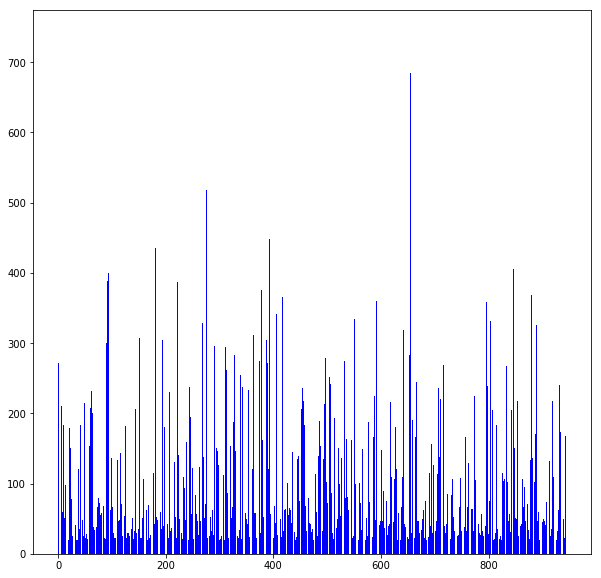

In [65]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.bar(list(user_freq.keys()), user_freq.values(), color='b')
plt.show()


In [66]:
print(np.mean(list(user_freq.values())))
print(np.median(list(user_freq.values())))

106.04453870625663
65.0


In [67]:
tau = np.median(list(user_freq.values()))

In [68]:
user_over_tau = {k:v for (k,v) in user_freq.items() if v> tau}
user_under_tau = {k:v for (k,v) in user_freq.items() if v <= tau}

In [69]:
user_over_tau_df = rating_df[rating_df['userID'].isin(list(user_over_tau.keys()))]
user_under_tau_df = rating_df[rating_df['userID'].isin(list(user_under_tau.keys()))]

In [70]:
user_over_tau_cosine_recsys = SimBasedRecSys('user','cosine')
user_over_tau_cosine_recsys.predict_all(user_over_tau_df, num_users, num_items)
user_over_tau_cosine_recsys.getModel()

array([[3.91041011, 3.1908566 , 3.00235737, ..., 2.        , 3.        ,
        3.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.92559031, 3.21751456, 2.96069275, ..., 2.        , 3.        ,
        3.        ],
       [3.92850668, 3.2432622 , 3.0603311 , ..., 0.        , 3.        ,
        3.        ]])

In [71]:
user_over_tau_cosine_recsys = SimBasedRecSys('item','cosine')
user_over_tau_cosine_recsys.predict_all(user_over_tau_df, num_users, num_items)
user_over_tau_cosine_recsys.getModel()

array([[3.74622788, 3.67506154, 3.73701178, ..., 3.65660155, 3.80213713,
        3.91005592],
       [3.88679245, 3.20769231, 2.975     , ..., 2.        , 3.        ,
        3.        ],
       [3.88679245, 3.20769231, 2.975     , ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.88679245, 3.20769231, 2.975     , ..., 2.        , 3.        ,
        3.        ],
       [4.35210602, 4.36235364, 4.30060325, ..., 3.95331038, 4.4040219 ,
        4.56988753],
       [3.51414117, 3.48366119, 3.53167665, ..., 0.        , 3.62344873,
        3.60359156]])

In [72]:
user_under_tau_cosine_recsys = SimBasedRecSys('user','cosine')
user_under_tau_cosine_recsys.predict_all(user_under_tau_df, num_users, num_items)
user_under_tau_cosine_recsys.getModel()

array([[0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [3.87477127, 3.        , 3.36462318, ..., 3.70967742, 3.70967742,
        3.70967742],
       [3.89477797, 3.        , 3.72767284, ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [3.90454422, 3.        , 3.70474559, ..., 4.04545455, 4.04545455,
        4.04545455],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan]])

In [73]:
user_under_tau_cosine_recsys = SimBasedRecSys('item','cosine')
user_under_tau_cosine_recsys.predict_all(user_under_tau_df, num_users, num_items)
user_under_tau_cosine_recsys.getModel()

array([[3.85820896, 3.        , 3.5       , ...,        nan,        nan,
               nan],
       [3.88165925, 3.64543554, 3.76371047, ..., 0.        , 0.        ,
        0.        ],
       [2.84274538, 3.10030064, 2.93460732, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.15088112, 4.09806381, 3.96560465, ..., 0.        , 0.        ,
        0.        ],
       [3.85820896, 3.        , 3.5       , ...,        nan,        nan,
               nan],
       [3.85820896, 3.        , 3.5       , ...,        nan,        nan,
               nan]])

In [74]:
class tau_CrossValidation(object):
    def __init__(self, metric,tau):
        """
            INPUT:
                metric: string. from['RMSE']
        """
        data_path=MOVIELENS_DIR
        
        self.tau = tau
        self.folds = self._getData(MOVIELENS_DIR, self.tau)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):

        switcher = {
            'RMSE': self.rmse,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    

    @staticmethod
    def getMatrix(user_over_tau_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in user_over_tau_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path, tau):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            
            
            if tau == 'over':
                test_set = test_set[test_set['userID'].isin(list(user_over_tau.keys()))]
            elif tau == 'under':
                test_set = test_set[test_set['userID'].isin(list(user_under_tau.keys()))]
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [75]:
tau_algorithm_instances = [user_cosine_recsys,
                      item_cosine_recsys]

In [76]:
tau_over_cv_rmse = tau_CrossValidation('RMSE','over')
tau_over_rmse_result = tau_over_cv_rmse.run(tau_algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


16695it [00:04, 3497.19it/s]
16683it [00:04, 3560.99it/s]
16458it [00:04, 3573.34it/s]
16432it [00:04, 3509.45it/s]
16376it [00:04, 3569.28it/s]
0it [00:00, ?it/s]

Processing algorithm item-cosine


16695it [00:04, 3538.82it/s]
16683it [00:04, 3553.83it/s]
16458it [00:04, 3551.21it/s]
16432it [00:04, 3581.68it/s]
16376it [00:04, 3539.32it/s]


In [77]:
tau_over_rmse_result

{'user-cosine': [[1.0220295846355458,
   1.0106425746588974,
   1.0070053630303846,
   1.0004152964535435,
   1.008430022746449],
  1.0097045683049641,
  0.9999279597419447,
  1.0194811768679837],
 'item-cosine': [[1.0391892811242678,
   1.0164750205325996,
   1.005030344113541,
   1.00651806213055,
   1.0135812707780274],
  1.0161587957357974,
  0.9991120889890304,
  1.0332055024825644]}

In [78]:
tau_over_rmse_df = pd.DataFrame(columns = list(tau_over_rmse_result.keys()),index=range(4))
for elem in list(tau_over_rmse_df.keys()):
    tau_over_rmse_df[elem].iloc[0] = tau_over_rmse_result[elem][0]
    tau_over_rmse_df[elem].iloc[1] = tau_over_rmse_result[elem][1]
    tau_over_rmse_df[elem].iloc[2] = tau_over_rmse_result[elem][2]
    tau_over_rmse_df[elem].iloc[3] = tau_over_rmse_result[elem][3]
tau_over_rmse_df = tau_over_rmse_df.rename(index={0: '5-fold score', 1: 'mean', 2: 'ci low',3:'ci high'})
tau_over_rmse_df

,user-cosine,item-cosine
5-fold score,"[1.0220295846355458, 1.0106425746588974, 1.007...","[1.0391892811242678, 1.0164750205325996, 1.005..."
mean,1.0097,1.01616
ci low,0.999928,0.999112
ci high,1.01948,1.03321


In [79]:
tau_under_cv_rmse = tau_CrossValidation('RMSE','under')
tau_under_rmse_result = tau_under_cv_rmse.run(tau_algorithm_instances, num_users, num_items,k=5)

0it [00:00, ?it/s]

Processing algorithm user-cosine


3305it [00:00, 3623.22it/s]
3317it [00:00, 3723.84it/s]
3542it [00:00, 3752.56it/s]
3568it [00:01, 3553.16it/s]
3624it [00:00, 3738.83it/s]
0it [00:00, ?it/s]

Processing algorithm item-cosine


3305it [00:00, 3697.25it/s]
3317it [00:00, 3747.14it/s]
3542it [00:00, 3727.08it/s]
3568it [00:00, 3601.00it/s]
3624it [00:00, 3629.09it/s]


In [80]:
tau_under_rmse_result

{'user-cosine': [[1.0484888012831624,
   1.0740945155945423,
   1.0420167492728771,
   1.0497880698148294,
   1.050532459788597],
  1.0529841191508016,
  1.0377469579605318,
  1.0682212803410713],
 'item-cosine': [[1.0305288300885578,
   1.0418556833159958,
   1.0337829506154919,
   1.046048550857087,
   1.0380463905058503],
  1.0380524810765965,
  1.0303672998112876,
  1.0457376623419055]}

In [81]:
tau_under_rmse_df = pd.DataFrame(columns = list(tau_under_rmse_result.keys()),index=range(4))
for elem in list(tau_under_rmse_df.keys()):
    tau_under_rmse_df[elem].iloc[0] = tau_under_rmse_result[elem][0]
    tau_under_rmse_df[elem].iloc[1] = tau_under_rmse_result[elem][1]
    tau_under_rmse_df[elem].iloc[2] = tau_under_rmse_result[elem][2]
    tau_under_rmse_df[elem].iloc[3] = tau_under_rmse_result[elem][3]
tau_under_rmse_df = tau_under_rmse_df.rename(index={0: '5-fold score', 1: 'mean', 2: 'ci low',3:'ci high'})
tau_under_rmse_df

,user-cosine,item-cosine
5-fold score,"[1.0484888012831624, 1.0740945155945423, 1.042...","[1.0305288300885578, 1.0418556833159958, 1.033..."
mean,1.05298,1.03805
ci low,1.03775,1.03037
ci high,1.06822,1.04574


Reommender for (i) has a slightly lower RMSE mean value and a narrower CI interval than reccomender for (ii). This is because (i) has more user ratings which means larger sample size.